In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.4.1


In [4]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder

import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import time

In [5]:
%store -r data_ready

In [6]:
#print(data_ready['category'].value_counts())
cat_index = data_ready['category'].value_counts().index

In [28]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x[:-1], acc[1:], 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x[:-1], loss[1:], 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [8]:
select_data = data_ready[data_ready['category'].isin(['hep-ph','hep-th','quant-ph'])].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"],
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data_ready['clean_text'][:100])

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = np.array([len(a) for a in X_train]).max()

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)

dummy_y_train = to_categorical(encoded_y_train)
dummy_y_test = to_categorical(encoded_y_test)

In [16]:
def create_cnn_model(embedding_dim = 50, n_filters = 64):
    model = Sequential(name="Convolutional Neural Network")
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(filters = n_filters, kernel_size = 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# define the grid search parameters
cand_ep = [5, 10, 20][:1] #number of epochs
cand_bs = [1024, 2048, 4096][2:] #batch size
cand_ed = [50, 100, 200][:1] #dimension of output of embedding layer
cand_nf = [16, 32, 64][:1] #number of filters convolutional layer
#OTHER HYPERPARAMETERS TO OPTIMIZE: Number of convolutional layers, kernel dimension

model = KerasClassifier(build_fn=create_cnn_model, verbose=0)
param_grid = dict(batch_size=cand_bs, epochs=cand_ep, embedding_dim=cand_ed, n_filters=cand_nf)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

In [17]:
s = time.time()
grid_result = grid.fit(X_train, dummy_y_train)
f = time.time()

print(f-s)

C:\Users\Matteo\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

cv_results = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')
cnn_cv_results0 = cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                              'split2_test_score', 'split3_test_score', 'split4_test_score'], 1)
clist = list(cnn_cv_results0.columns.values)
cnn_cv_results0 = cnn_cv_results0[clist[-2:] + clist[:-2]]
%store cnn_cv_results0
cnn_cv_results0

In [21]:
model = create_cnn_model(embedding_dim = 50, n_filters = 16)
model.summary()

Model: "Convolutional Neural Network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 193, 50)           92400     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 189, 16)           4016      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                170       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 33        
Total params: 96,619
Trainable params: 96,619
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_train, dummy_y_train, epochs=5, verbose=True, validation_data=(X_test, dummy_y_test), batch_size=4096)

Epoch 1/5
27/27 [==============================] - 20s 739ms/step - loss: 1.0799 - accuracy: 0.4658 - val_loss: 0.9787 - val_accuracy: 0.6429
Epoch 2/5
27/27 [==============================] - 20s 758ms/step - loss: 0.9073 - accuracy: 0.6810 - val_loss: 0.6536 - val_accuracy: 0.8326
Epoch 3/5
27/27 [==============================] - 19s 714ms/step - loss: 0.5593 - accuracy: 0.8715 - val_loss: 0.3330 - val_accuracy: 0.9190
Epoch 4/5
27/27 [==============================] - 19s 715ms/step - loss: 0.2820 - accuracy: 0.9266 - val_loss: 0.2125 - val_accuracy: 0.9271
Epoch 5/5
27/27 [==============================] - 20s 730ms/step - loss: 0.1920 - accuracy: 0.9345 - val_loss: 0.1871 - val_accuracy: 0.9306


Training Accuracy: 0.9390
Testing Accuracy:  0.9306


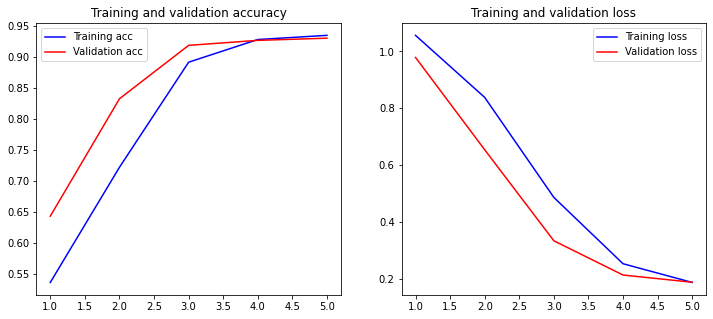

In [23]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

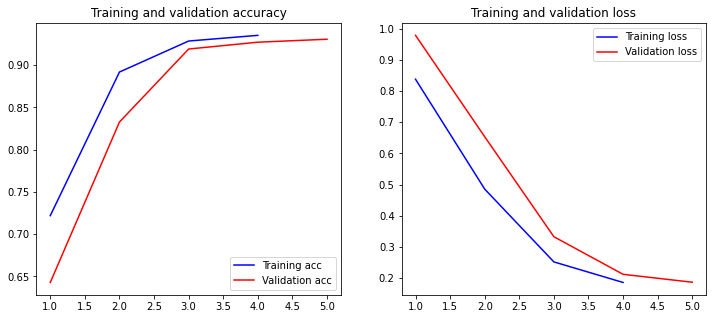

In [29]:
plot_history(history)